In [133]:
import numpy as np
import numpy.random as rnd
import itertools 
import os
import sys
import scipy.misc
import random

# We used some utilities from sklearn
from sklearn.preprocessing import StandardScaler

#PyTorch
import torch
from torch import nn
from torch.optim import Adam, SGD
from torchinfo import summary
from torch.autograd  import Variable

# Used for plotting and display of figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


from IPython.display import display
from IPython.display import Image
from IPython.display import SVG

In [134]:
import pandas as pd
df = pd.read_csv('data_akbilgic.csv')


In [135]:
df

,date,ISE,ISE.1,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
0,5-Jan-09,0.035754,0.038376,-0.004679,0.002193,0.003894,0.000000,0.031190,0.012698,0.028524
1,6-Jan-09,0.025426,0.031813,0.007787,0.008455,0.012866,0.004162,0.018920,0.011341,0.008773
2,7-Jan-09,-0.028862,-0.026353,-0.030469,-0.017833,-0.028735,0.017293,-0.035899,-0.017073,-0.020015
3,8-Jan-09,-0.062208,-0.084716,0.003391,-0.011726,-0.000466,-0.040061,0.028283,-0.005561,-0.019424
4,9-Jan-09,0.009860,0.009658,-0.021533,-0.019873,-0.012710,-0.004474,-0.009764,-0.010989,-0.007802
...,...,...,...,...,...,...,...,...,...,...
531,16-Feb-11,0.008599,0.013400,0.006238,0.001925,0.007952,0.005717,0.018371,0.006975,0.003039
532,17-Feb-11,0.009310,0.015977,0.003071,-0.001186,0.000345,0.002620,0.001686,-0.000581,0.001039
533,18-Feb-11,0.000191,-0.001653,0.001923,0.002872,-0.000723,0.000568,0.005628,0.000572,0.006938
534,21-Feb-11,-0.013069,-0.013706,-0.020742,-0.014239,-0.011275,0.001358,-0.011942,-0.012615,-0.000958


In [136]:
#main dataset,ratio -> train,test
def split(df,train_size=0.8):
    size = df.shape[0]
    train_set_size = int(size*train_size)
    #chosing desired columns
    df_train = df.iloc[:train_set_size,2:-1]
    df_test = df.iloc[train_set_size:,2:-1]
    return df_train,df_test

In [137]:
df_train,df_test = split(df)
df_train,df_test = split(df,train_size=0.8)
print(f'data set samples:\t {df.shape[0]}\ntrainset samples:\t {df_train.shape[0]} \ntestset samples:\t {df_test.shape[0]}')


data set samples:	 536
trainset samples:	 428 
testset samples:	 108


In [138]:
#dataset, steps -> timeseries x(steps,features) concatenated to y(steps,)
def timeseries(df,step):
    rows,columns = df.shape
    result =[]
    x = None
    y = None
    result = []
    for i in range(rows-step):
        #casting desired sub set into array
        x = df.iloc[i:i+step,0].values
        y = df.iloc[i+1:i+step+1,0].values
        result.append(np.append(x.reshape(-1,1),y.reshape(-1,1),axis=1))
    return np.array(result)

In [139]:
from torch.utils.data import TensorDataset,DataLoader
def dataload(batch_size,n_steps,df_base,train=True):
    data = timeseries(df_base,n_steps)
    x = data[:,:,:-1]
    y = data[:,:,-1]
    x,y = torch.tensor(x,dtype=torch.float32),torch.tensor(y,dtype=torch.float32)
    #generates dataset from tensors
    dataset = TensorDataset(x,y)
    #contructs dataloader
    loader = DataLoader(dataset,batch_size=batch_size,shuffle=train,drop_last=True)
    return loader

In [140]:
loader = dataload(5,5,df_train,train=True)

In [141]:
x,y = iter(loader).next()

In [142]:
y.shape

torch.Size([5, 5])

In [143]:
import torch.nn.functional as F
class LSTM(nn.Module):
    def __init__(self,input_dim,hidden_dim,n_layer,output_dim,batch_size):
        super(LSTM,self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layer = n_layer
        self.output_dim = output_dim
        self.batch_size = batch_size
        self.lstm = nn.LSTM(self.input_dim,self.hidden_dim,self.n_layer,batch_first=True)
        self.fc = nn.Linear(self.hidden_dim,self.output_dim)

    def forward(self,x):
        h0 = torch.zeros(self.n_layer,self.batch_size,self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.n_layer,self.batch_size,self.hidden_dim).requires_grad_()

        out,(h_t,c_t) = self.lstm(x,(h0,c0))
        h = h_t[-1]
        out = self.fc(F.relu(h))

        return out

        

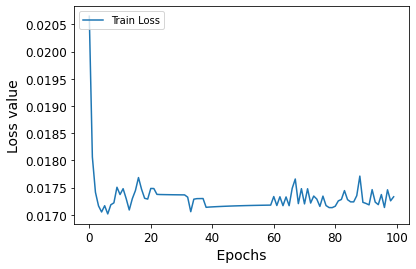

In [144]:
in_dim =1
out_dim=1


# #how many squence there will be in a bacth
batch_size = 6
#after how many operations we will print information
printing_gap = 2

epochs = 100
#We will store the loss values here to plot them
n_seq = 6
model = LSTM(in_dim,50,1,out_dim,batch_size)

# What would be an adecuate loss function?
criterion =  nn.L1Loss()

# optimizer to apply the gradients
optim = Adam(model.parameters(),lr=0.01)

#number of batches we will go through


train_loss = []


train_loss = []
loader = dataload(batch_size,n_seq,df_train,train=False)
# for iter in range(n_iterations):
losses=[]
for epoch in range(epochs):
    train_loss = []
    for x,labels in loader:
        
        #Reset the gradients
        optim.zero_grad()
        #Get the outputs
        out = model.forward(x)
        #compute the loss
        loss = criterion(out.squeeze(-1),labels[:,-1])
        #compute the gradients
        loss.backward()
        #Apply the gradients
        optim.step()

        #Append the loss value
        train_loss.append(loss.item())

        # if iter % printing_gap == 0:
        #     pass
        #     #Print the information
    losses.append(np.mean(train_loss))

plt.plot(losses, label= "Train Loss")
plt.xlabel(" Epochs ")
plt.ylabel("Loss value")
plt.legend(loc="upper left")
plt.show()




In [145]:
testload = dataload(batch_size,n_seq,df_train,False)

In [146]:
with torch.no_grad():
    model.eval()
    ground_truth = []
    pred= []
    for x_test, y_test in testload:
        out= model.forward(x)
        pred_test = out.squeeze(-1)
        label = y_test[:,-1]
        loss = criterion(pred_test,label)
        ground_truth.extend(label.tolist())
        pred.extend(pred_test.tolist())


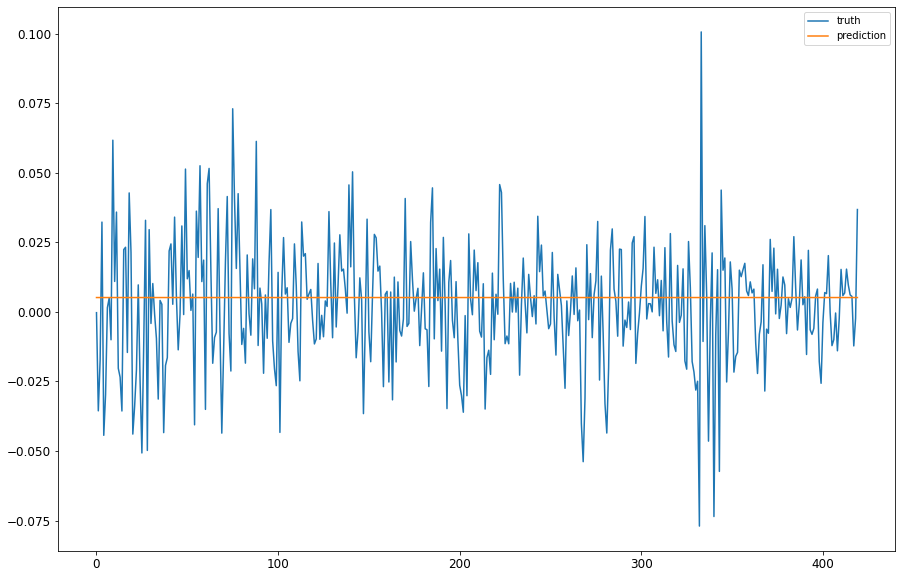

In [147]:
plt.figure(figsize=(15,10))
plt.plot(ground_truth,label='truth')
plt.plot(pred,label='prediction')
plt.legend()